In [1]:
import subprocess as sb
import os
import glob
import nibabel
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

%matplotlib inline

Outline
- Load image and determine
- Load surface files
- Overlay image and surface files

In [5]:
subjDir = "/Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/"
subjDir = "/Volumes/youngjm_ext/Data/clip/rawdata_mpr-dti/"

In [6]:
subjs = [i for i in os.listdir(subjDir) if "sub-" in i]
print(len(subjs))

615


In [7]:
# FS_folder = "/Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM9BLERT0/ses-0427age05903/anat/sub-HM9BLERT0_ses-0427age05903_acq-MprPrimary3p0UnknownContrastFromScanner35008_run-01_T1w/"

In [4]:
def selectSliceIndices(brainMin, brainMax):
    randRange = int(round((brainMax - brainMin)*0.05))
    # Get the slices for each dimension
    slice1 = int((brainMax - brainMin)/4 + brainMin + random.randint(-randRange, randRange))
    slice2 = int((brainMax - brainMin)/2 + brainMin + random.randint(-randRange, randRange))
    slice3 = int((brainMax - brainMin)*3/4 + brainMin + random.randint(-randRange, randRange))
    
    return [slice1, slice2, slice3]


def checkSliceHasTissue(brainSlice):
    # Make sure at least 10% of the brainSlice is actually not brain
    totalPixels = len(brainSlice)*len(brainSlice[0])
    nonzeroPixels = np.count_nonzero(brainSlice)
    
    if (nonzeroPixels >= 0.1*totalPixels):
        return True
    else:
        return False
    

def selectBrainSlices(fn):
    # Load the masked brain image
    nibImg = nibabel.load(fn)
    img = nibImg.get_fdata()

    # # What volumes do we want? 
    # # Third dim: 0 is back of head? max is front of head? AP view
    # # Second dim: coronal, 0 is top and max is bottom of skull
    # # First dim: sagittal? LR

    # Goal: identify volume of brain that's non-zero
    # Get the upper and lower bounds of brain in each dimension
    dim0Lims, dim1Lims = np.where(img.any(axis=2))
    _, dim2Lims = np.where(img.any(axis=1))

    # Get the min and max of each dimension
    dim0MinBrain = sorted(set(dim0Lims))[0]
    dim0MaxBrain = sorted(set(dim0Lims))[-1]
    dim1MinBrain = sorted(set(dim1Lims))[0]
    dim1MaxBrain = sorted(set(dim1Lims))[-1]
    dim2MinBrain = sorted(set(dim2Lims))[0]
    dim2MaxBrain = sorted(set(dim2Lims))[-1]

    dim0Slices = selectSliceIndices(dim0MinBrain, dim0MaxBrain)
    while not all([checkSliceHasTissue(img[i, :, :]) for i in dim0Slices]):
        print("regenerate")
        dim0Slices = selectSliceIndices(dim0MinBrain, dim0MaxBrain)
    plt.figure()
    plt.imshow(img[dim0Slices[0], :, :]) 
    plt.figure()
    plt.imshow(img[dim0Slices[1], :, :])
    plt.figure()
    plt.imshow(img[dim0Slices[2], :, :])


    dim1Slices = selectSliceIndices(dim1MinBrain, dim1MaxBrain)
    while not all([checkSliceHasTissue(img[:, i, :]) for i in dim1Slices]):
        print("regenerate")
        dim1Slices = selectSliceIndices(dim1MinBrain, dim1MaxBrain)
    plt.figure()
    plt.imshow(img[:, dim1Slices[0], :])
    plt.figure()
    plt.imshow(img[:, dim1Slices[1], :])
    plt.figure()
    plt.imshow(img[:, dim1Slices[2], :])

    dim2Slices = selectSliceIndices(dim2MinBrain, dim2MaxBrain)
    while not all([checkSliceHasTissue(img[:, :, i]) for i in dim2Slices]):
        print("regenerate")
        dim2Slices = selectSliceIndices(dim2MinBrain, dim2MaxBrain)
    plt.figure()
    plt.imshow(img[:, :, dim2Slices[0]])
    plt.figure()
    plt.imshow(img[:, :, dim2Slices[1]])
    plt.figure()
    plt.imshow(img[:, :, dim2Slices[2]])
    
    return [dim0Slices, dim1Slices, dim2Slices]



In [6]:
##################################################################################################################
#
#   This script uses freeview to make screenshots of a freesurfer segmentation.
#   These screenshots are then combined to a movie, for easy diagnosis of 
#   FreeSurfer segmentation problems. I have chosen for sagittal orientation, 
#   because this allows one to see whether the sagittal sinus is misclassified as V1 gray matter. 
#
#   Adapted from: https://gist.github.com/tknapen/85d9a23a09c95d15f4b23ba1965fa54d
# 
##################################################################################################################


# coordinates of the images are in (x, z, y)

def generatePngsSingleScanFreeview(FS_folder, subject, outputDir):
    freeview_command = 'freeview -cmd {cmd} '
    cmd_txt = """ -v {anatomy}:grayscale=10,100 -f {lh_wm}:color=blue:edgecolor=blue -f {rh_wm}:color=blue:edgecolor=blue -f {lh_pial}:color=red:edgecolor=red -f {rh_pial}:color=red:edgecolor=red
     """  

    # To step through the sagittal slices this is added for every slice. 
    dim0_slice = ' -slice {xpos} 127 127 \n -ss {opfn} \n  '  
    dim1_slice = ' -slice 127 127 {xpos} \n -ss {opfn} \n  '  
    dim2_slice = ' -slice 127 {xpos} 127 \n -ss {opfn} \n  '  

    # Set up variables 
    mprFn = os.path.join(FS_folder, 'mri', 'norm.mgz')          # Want to use the images without the face
    target_directory = outputDir
    os.makedirs(target_directory, exist_ok=True)
    cmd_file_x = os.path.join(target_directory, 'cmd_x.txt')
    cmd_file_y = os.path.join(target_directory, 'cmd_y.txt')
    cmd_file_z = os.path.join(target_directory, 'cmd_z.txt')

    # Start writing the command string
    sj_cmd = cmd_txt.format(
        anatomy=mprFn,
        lh_wm=os.path.join(FS_folder, 'surf', 'lh.white'),
        lh_pial=os.path.join(FS_folder, 'surf', 'lh.pial'),
        rh_wm=os.path.join(FS_folder, 'surf', 'rh.white'),
        rh_pial=os.path.join(FS_folder, 'surf', 'rh.pial'),
        subject=subject
    )

    brainSlices = selectBrainSlices(mprFn)
    
    sj_cmd_x = sj_cmd + " -viewport x "
    sj_cmd_y = sj_cmd + " -viewport y "
    sj_cmd_z = sj_cmd + " -viewport z "


    for dim0Slice in brainSlices[0]:
        sj_cmd_x += dim0_slice.format(
            xpos=dim0Slice,
            opfn=os.path.join(target_directory, subject+"_dim0_"+str(
                dim0Slice).zfill(3) + '.png')
        ) 

    for dim1Slice in brainSlices[1]:
        sj_cmd_y += dim1_slice.format(
            xpos=dim1Slice,
            opfn=os.path.join(target_directory, subject+"_dim1_"+str(
                dim1Slice).zfill(3) + '.png')
        ) 

    for dim2Slice in brainSlices[2]:
        sj_cmd_z += dim2_slice.format(
            xpos=dim2Slice,
            opfn=os.path.join(target_directory, subject+"_dim2_"+str(
                dim2Slice).zfill(3) + '.png') 
        ) 

    with open(cmd_file_x, 'w') as f:
        sj_cmd_x += ' -quit \n '
        print(sj_cmd_x)
        f.write(sj_cmd_x)
        
    with open(cmd_file_y, 'w') as f:
        sj_cmd_y += ' -quit \n '
        print(sj_cmd_y)
        f.write(sj_cmd_y)
        
    with open(cmd_file_z, 'w') as f:
        sj_cmd_z += ' -quit \n '
        print(sj_cmd_z)
        f.write(sj_cmd_z)

    sb.call(freeview_command.format(cmd=cmd_file_x), shell=True)
    sb.call(freeview_command.format(cmd=cmd_file_y), shell=True)
    sb.call(freeview_command.format(cmd=cmd_file_z), shell=True)

    
    print("PNGs generated for", subject)

sub-HM916U05LD_ses-9001age00648_acq-MprPrimary3p0UnknownContrastFromScanner45195_run-03_T1w
regenerate
 -v /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM916U05LD/ses-9001age00648/anat/sub-HM916U05LD_ses-9001age00648_acq-MprPrimary3p0UnknownContrastFromScanner45195_run-03_T1w/mri/norm.mgz:grayscale=10,100 -f /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM916U05LD/ses-9001age00648/anat/sub-HM916U05LD_ses-9001age00648_acq-MprPrimary3p0UnknownContrastFromScanner45195_run-03_T1w/surf/lh.white:color=blue:edgecolor=blue -f /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM916U05LD/ses-9001age00648/anat/sub-HM916U05LD_ses-9001age00648_acq-MprPrimary3p0UnknownContrastFromScanner45195_run-03_T1w/surf/rh.white:color=blue:edgecolor=blue -f /Users/youngjm/Data/clip/images/derivatives/mpr_fs_reconall_6.0.0/sub-HM916U05LD/ses-9001age00648/anat/sub-HM916U05LD_ses-9001age00648_acq-MprPrimary3p0UnknownContrastFromScanner45195_run-0

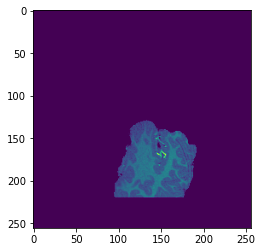

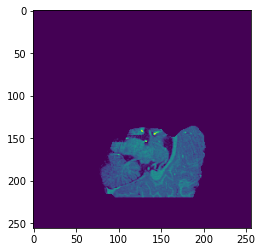

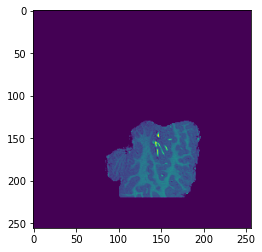

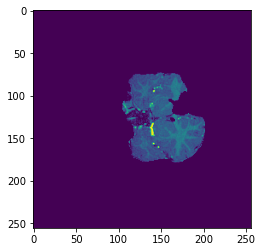

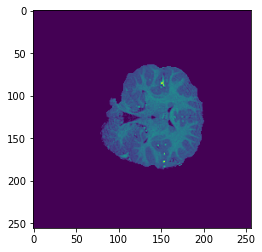

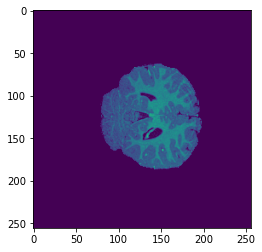

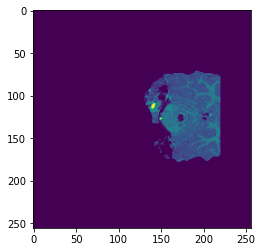

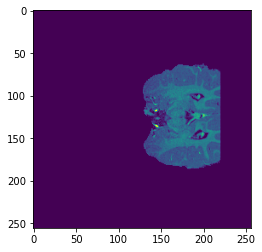

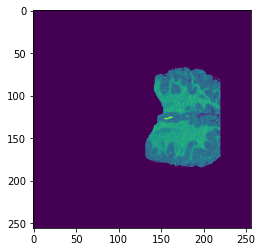

In [9]:
# Load the csv containing the list of the scans I want graded
fn = '/Users/youngjm/Data/chop-nf1/nf1_mpr_fs_reconall_6.0.0_structural_stats.csv'
df = pd.read_csv(fn)

outputDir = "/Users/youngjm/Data/chop-nf1/derivatives/qc_mpr_fs_6.0.0/pngs"

# Get the ids of the scans we want graded
scanIds = df['scan_id'].values

# For each scan
# for scanId in scanIds:
scanId = scanIds[0]
print(scanId)
# Identify the complete path to the scan
subj = scanId.split("_")[0]
ses = scanId.split("_")[1]

scanPath = subjDir+subj+"/"+ses+"/anat/"+scanId+"/"
generatePngsSingleScan(scanPath, subj, outputDir)
    
    

In [ ]:
def generatePngsSingleScanMatplotlib(fn, outputDir):

    # Set up variables - change this
    mprFn = os.path.join(baseDir, 'mri', 'norm.mgz')          # Want to use the images without the face
    target_directory = outputDir
    os.makedirs(target_directory, exist_ok=True)

    brainSlices = selectBrainSlices(mprFn)

    for dim0Slice in brainSlices[0]:
        # isolate the individual slices

    for dim1Slice in brainSlices[1]:
        sj_cmd_y += dim1_slice.format(
            xpos=dim1Slice,
            opfn=os.path.join(target_directory, subject+"_dim1_"+str(
                dim1Slice).zfill(3) + '.png')
        ) 

    for dim2Slice in brainSlices[2]:
        sj_cmd_z += dim2_slice.format(
            xpos=dim2Slice,
            opfn=os.path.join(target_directory, subject+"_dim2_"+str(
                dim2Slice).zfill(3) + '.png') 
        ) 
    
    print("PNGs generated for", subject)

In [ ]:
df['scan_id'].values